# Histopathologic Cancer Detection

## Introduction
This project represents the analysis of scanned medical images to train a Convolutional Neural Network (CNN) with the goal of predicting the presence of histopathologic cancer. This binary classification project is part of the Coursera course, Introduction to Deep Learning, and is a pathway course for a Masters of Science for University of Colorado, Boulder.

### Project Goal
The project utilizes a Kaggle competition, which provides hundreds of thousands of labeled training images, with the goal of submitting a binary classification file of approximately fifty thousand testing images. The UC Boulder component requires analysis to determine the best way to configure and train a CNN to improve the accuracy when presented with the testing images. The goal is not to win the Kaggle competition, since it closed long ago, but rather to explore different model archtectures to get a CNN to classify the images with reasonable accuracy.

## Exploratory Data Analysis (EDA)
The first phase of this project is to explore and understand the data provided by Kaggle. This data analysis will help determine if the data is suitable for CNN training and if it requires any form of normalization or cleanup to maximize the model's accuracy.

### Data Description
The dataset includes training and testing data, as well as a CSV file indicating the correct label for each training image. 

Each training and testing image is 96x96 pixels, which allows the model to focus on the center 32x32 pixel patch and not worry about padding. The images are `.tif` files and do not include labeling. The model must classify the image with 1, indicating the presence of metastatic cancer if any pixel within the centered, 32x32 patch is cancerous. If the image is not considered cancerous, it should be classified as 0.

### Training Data
The training data is provided in many, unlabeled images and one label classification file, `train_labels.csv` where the `id` column corresponds to the base filename of the training image files (minus the `.tif` extension) and the `label` column indicates the binary classification (0=cancer-free, 1=cancerous). There are 220,025 image files and corresponding rows in the CSV file.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator # pyright: ignore[reportMissingImports]
from tensorflow.keras.models import Sequential, load_model # pyright: ignore[reportMissingImports]
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation # pyright: ignore[reportMissingImports]
from tensorflow.keras.preprocessing.image import ImageDataGenerator # pyright: ignore[reportMissingImports]
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # pyright: ignore[reportMissingImports]
from tensorflow.keras.utils import plot_model # pyright: ignore[reportMissingImports]
from tensorflow.keras.regularizers import l1, l2, l1_l2 # pyright: ignore[reportMissingImports]
from tensorflow.keras.optimizers import Adam, RMSprop # pyright: ignore[reportMissingImports]
from tensorflow.keras.preprocessing.image import load_img, img_to_array # pyright: ignore[reportMissingImports]
from tensorflow.keras import regularizers # pyright: ignore[reportMissingImports]
from pathlib import Path
from PIL import Image

DATA_DIR = 'histopathologic-cancer-detection'

def id_to_filename(id): return f"{id}.tif"
def train_path_from_id(id): return f"{DATA_DIR}/train/{id}.tif"
def test_path_from_id(id):  return f"{DATA_DIR}/test/{id}.tif"

train_csv_path = os.path.join(DATA_DIR, 'train_labels.csv')
train_images_path = os.path.join(DATA_DIR, 'train')
test_images_path = os.path.join(DATA_DIR, 'test')

train_source_df = pd.read_csv(train_csv_path)
train_source_df['image_name'] = train_source_df['id'].apply(id_to_filename)

print('Shape of train_labels.csv =', train_source_df.shape)
print('\nSample rows from train_source_df:')
display(train_source_df.drop('id', axis=1).head())

missing_data = train_source_df.isnull()
missing_ids, missing_labels = missing_data['id'].sum(), missing_data['label'].sum()
print(f"\nThere are {missing_ids} missing ids and {missing_labels} missing labels in `train_labels.csv`")

print()
if 'train_file_count' not in globals():
    print('Matching training image files...')
    train_file_count = 0
    train_missing_count = 0
    for id in train_source_df['id']:
        p = train_path_from_id(id)
        if not Path(p).exists():
            train_missing_count += 1
        train_file_count += 1
print(f"There are {train_file_count:,} training images and {train_missing_count} missing image files for each `id` in `train_labels.csv`")

unique_values = train_source_df['label'].unique()
print(f"\nThe CSV file should have only 0's or 1's as labels. Unique values: {unique_values}")

print("\nDuplicate rows in training dataset:", sum(train_source_df.duplicated(keep=False)))

print()
if 'test_file_count' not in globals():
    print('Counting test image files...')
    test_file_count = sum(1 for file in Path(test_images_path).iterdir() if file.is_file())
print(f"There are {test_file_count:,} testing images")


Shape of train_labels.csv = (220025, 3)

Sample rows from train_source_df:


,label,image_name
0,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,0,068aba587a4950175d04c680d38943fd488d6a9d.tif



There are 0 missing ids and 0 missing labels in `train_labels.csv`

Matching training image files...
There are 220,025 training images and 0 missing image files for each `id` in `train_labels.csv`

The CSV file should have only 0's or 1's as labels. Unique values: [0 1]

Duplicate rows in training dataset: 0

Counting test image files...
There are 57,458 testing images


The great news is that there is a corresponding training image file for each id in *train_labels.csv*.

### Label Distribution

Here is a histogram showing the distribution of the two classes (0 and 1):

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

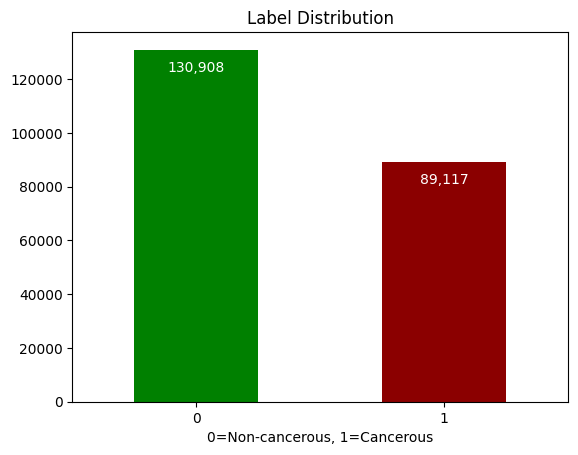

In [2]:
label_counts = train_source_df['label'].value_counts()
ax = label_counts.plot(kind='bar', color=['green', 'darkred'])
ax.bar_label(ax.containers[0], padding=-18, color='white', fmt='{:,.0f}') # type: ignore
plt.title('Label Distribution')
plt.xlabel('0=Non-cancerous, 1=Cancerous')
plt.xticks(rotation=0)


### Image Dimensions

Here is an analysis of 50 sample images to make sure they have the expected dimensions and number of color channels

In [3]:
train_img_shapes = set()
for row in train_source_df.sample(n=50, random_state=42).itertuples():
    img = mpimg.imread(train_path_from_id(row.id))
    train_img_shapes.add(img.shape)
print("Unique dimensions of 50 train images:", train_img_shapes)
print(f"At least with the set of random images, all of the dimensions are equivalent and expected (96x96 pixels, with 3 color channels)")

if 'test_count' not in globals():
    test_count = 0
    test_img_shapes = set()
    for file in Path(test_images_path).iterdir():
        if file.is_file() and test_count < 50:
            img = mpimg.imread(train_path_from_id(row.id))
            test_img_shapes.add(img.shape)
            test_count += 1
print("\nUnique dimensions of 50 test images:", train_img_shapes)
print(f"At least with the set of random images, all of the dimensions are equivalent and expected (96x96 pixels, with 3 color channels)")


Unique dimensions of 50 train images: {(96, 96, 3)}
At least with the set of random images, all of the dimensions are equivalent and expected (96x96 pixels, with 3 color channels)

Unique dimensions of 50 test images: {(96, 96, 3)}
At least with the set of random images, all of the dimensions are equivalent and expected (96x96 pixels, with 3 color channels)



#### Sample Training Images
A few examples of 0-classified (cancer-free) and 1-classified (cancerous) images are shown below


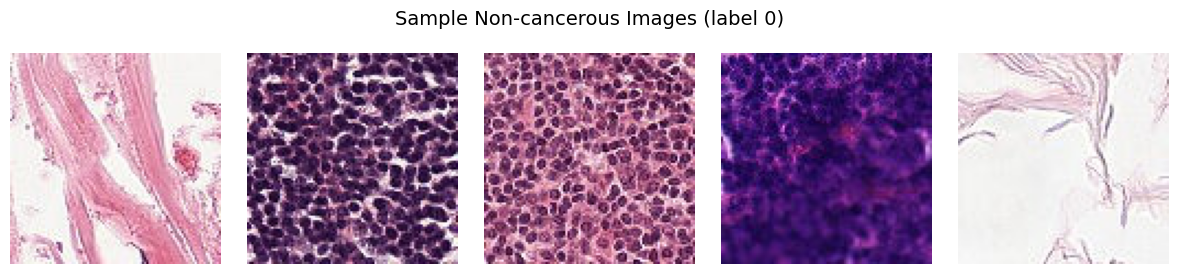

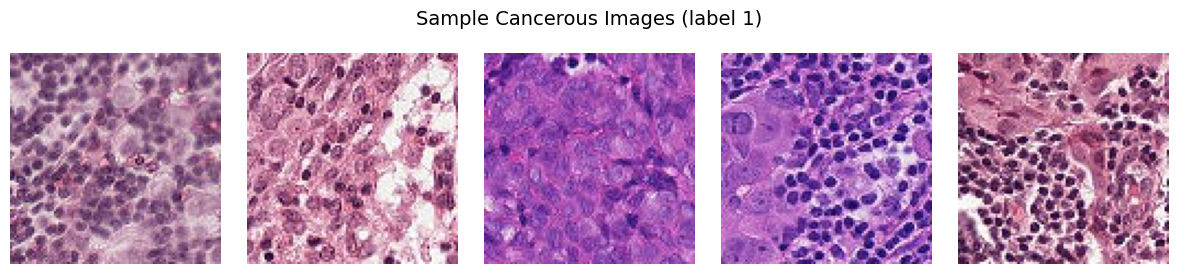

In [4]:
def display_images(title, images):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12,2.75))
    fig.suptitle(title, fontsize=14)
    for i, filename in enumerate(images):
        img = mpimg.imread(filename)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout() # Adjust layout to prevent titles from overlapping
    plt.show()

df_label_0 = train_source_df[train_source_df['label'] == 0]
df_label_1 = train_source_df[train_source_df['label'] == 1]
label_0_images = [train_path_from_id(row.id) for row in df_label_0.sample(n=5, random_state=42).itertuples()]
label_1_images = [train_path_from_id(row.id) for row in df_label_1.sample(n=5, random_state=42).itertuples()]

display_images('Sample Non-cancerous Images (label 0)', label_0_images)
display_images('Sample Cancerous Images (label 1)', label_1_images)

#### Sample Testing Images
A few test images (with unknown labels) are shown below

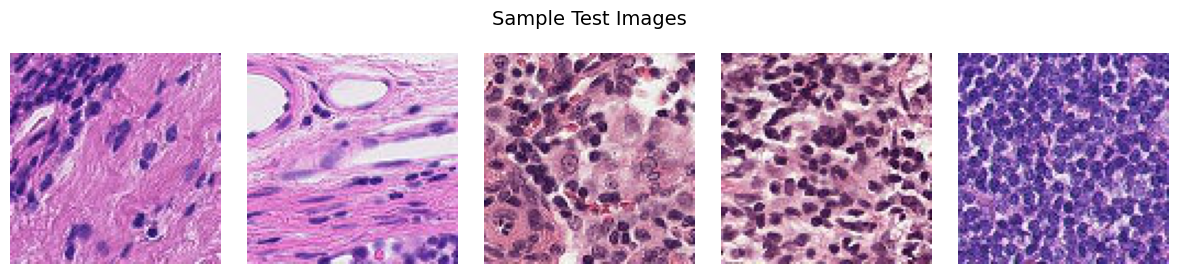

In [5]:
if 'sample_test_images' not in globals():
    sample_test_images = []
    for file in Path(test_images_path).iterdir():
        if file.is_file() and len(sample_test_images) < 5:
            sample_test_images.append(file)
display_images('Sample Test Images', sample_test_images)

### EDA Summary
All sampled images have the correct dimensions, and the CSV label file corresponds correctly with the number of images in the train folder. When visualizing the sample images, other than redness, it is hard to definitely identify cancerous vs. non-cancerous areas. This indicates that it will not be a trivial task to train a model and expect the accuracy to be near 100%.

I validated the CSV file to make sure an image file was present for each id. There were no errors, so there is no data cleaning necessary. In addition, kaggle has stated that they have already removed duplicate images. 

Regarding the training data, there are more non-cancerous images (130,908) vs. cancerous images (89,117); around a 19% difference in quantity. This could cause a model to improve accuracy simply by guessing the majority class. To compensate, when a model is fitted, we will adjust the class weights to penalize the majority class when predicted incorrectly.

CNNs might be sensitive to the scale of input data. The raw pixel values up to 255 values may calculate large numbers directly into the network, possibly leading to several problems:
- Slower Convergence: The network weights may adjust significantly, which can slow down the training.
- Vanishing/Exploding Gradients: We might get vanishing or exploding gradients during backpropagation. 
- Uneven Learning: The network might learn features from one color channel over others, which could change with real data.

To compensate for these deficiencies, I will normalize each color channel separately (across all images) to scale all pixel values to be centered around the mean of the channel's intensity and a standard deviation of 1. TensorFlow has nice utilities to perform those adjustments.

## Data Preparation
Based on the EDA, I will perform the following pre-processing activities:
1. Use a random sample of 50,000 images (~ 1/4 of training size) to experiment with model architectures since I have limited computing power.
2. Split the training data into 80%/20% train/test groups named `train_df` and `validate_df`
3. Calculate the mean and standard deviation of each color channel (RGB) across a sample of 500 images. These values (`channel_mean`, `channel_std`) will be used by TensorFlow's ImageDataGenerator to normalize images.

In [6]:
def generate_training_data(frac=1.0):
    df = train_source_df
    if frac != 1:
        assert frac > 0 and frac < 1, 'frac must be greater than 0 and less than 1'
        minority_label_count = min(list(df['label'].value_counts()))
        training_size = min(minority_label_count, int(train_source_df.shape[0] * frac) // 2)
        print(f"Using a subset of training images ({training_size:,})")
        df_0 = train_source_df[train_source_df['label'] == 0].sample(n=training_size, random_state=42)
        df_1 = train_source_df[train_source_df['label'] == 1].sample(n=training_size, random_state=42)
        df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True) # concat and sample to get a shuffled union

    print('Splitting data: 80% train, 20% test, and stratifying on label.')
    return train_test_split(
        df,
        test_size=0.2,
        stratify=df['label'], # type: ignore
        random_state=42
    )

# Create an ImageDataGenerator and call flow_from_dataframe()
def create_image_generator(df, image_path, channel_mean, channel_std, *, is_training, target_size=(64, 64)):
    gen = ImageDataGenerator(
        rescale=1/255.0,
        featurewise_center=True,
        featurewise_std_normalization=True,
        horizontal_flip=is_training,
        vertical_flip=is_training,
    )
    gen.mean = channel_mean
    gen.std = channel_std

    return gen.flow_from_dataframe(
        dataframe=df,
        shuffle=is_training,
        target_size=target_size,
        directory=image_path,
        x_col='image_name',
        y_col='label',
        class_mode='raw',
        batch_size=32,
    )


### Utility Functions

In [7]:
# Calculate mean, std for each of 3 color channels for a sample of images which will be
# used to normalize pixel values before training
def calc_image_stats(df, sample_size=500):
    num_channels = 3
    running_sum = np.zeros(num_channels)
    running_sum_sq = np.zeros(num_channels)
    total_pixels = 0

    print(f"Calculating mean and std for each color channel of {sample_size} images...")
    for row in df.sample(n=sample_size, random_state=42).itertuples():
        with Image.open(train_path_from_id(row.id)) as img:
            width, height = img.size
            img_array = np.asarray(img) / 255
            running_sum += np.sum(img_array, axis=(0, 1))
            running_sum_sq += np.sum(img_array**2, axis=(0, 1))
            total_pixels += (width * height)

    channel_mean = running_sum / total_pixels
    channel_std = np.sqrt(running_sum_sq / total_pixels - channel_mean**2)
    print(f"channel_mean: {channel_mean} channel_std: {channel_std}")
    return channel_mean, channel_std

# Plot the accuracy and loss graphs based on model epoch history
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    plt_accuracy, plt_loss = ax
    # Plot training & validation accuracy values
    plt_accuracy.plot(epochs, history.history['accuracy'])
    plt_accuracy.plot(epochs, history.history['val_accuracy'])
    plt_accuracy.set_title('Model accuracy')
    plt_accuracy.set_ylabel('Accuracy')
    plt_accuracy.set_xlabel('Epoch')
    plt_accuracy.set_xticks(epochs)
    plt_accuracy.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    plt_loss.plot(epochs, history.history['loss'])
    plt_loss.plot(epochs, history.history['val_loss'])
    plt_loss.set_title('Model loss')
    plt_loss.set_ylabel('Loss')
    plt_loss.set_xlabel('Epoch')
    plt_loss.set_xticks(epochs)
    plt_loss.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

import visualkeras
from collections import defaultdict

def show_3d_model(model, scale_xy=1):
    color_map = defaultdict(dict)
    color_map[MaxPooling2D]['fill'] = '#80c090' # Your desired color
    display(visualkeras.layered_view(model, legend=True, color_map=color_map, type_ignore=[Activation], scale_xy=scale_xy))

## Model Architecture
I will explore a few basic CNN architectures with a limited number of images to identify a base architecture. I will then perform hyperparameter tuning to discover the most accurate architecture with optimal hyperparameters. I will use the final model to validate the performance on the entire image dataset and create the kaggle submission.

To start off, I will use a basic pipeline from TensorFlow that has an Input layer, a configurable section of various layer types, followed by the final set of layers to convert the convolved learnings into a binary classs prediction.

To make things easier, a function, `create_model()` will take configurable parameters to control the variable layers in the middle of the pipeline, and it will prepend the Input layer and append the consolidation layers to do the final binary classification.

First, let me describe the variable layers. I can specify any number of repeatable blocks, where each block is one or more Conv2d layers (using a 3x3 kernel) with a ReLU activation at the end of each block. Each of those blocks can also have an optional BatchNormalization layer, which comes before the activation and ensures that all values are centered around a mean of 0 and have a variance of 1. The TensorFlow.Keras layer has reasonable defaults for controlling the mean and standard deviation, so I will use those. However, the `create_model` function will allow you to explore the difference in learning and accuracy by using the parameter, `normalize_batches` which defaults to `False`.

Other important parameters to this utility function are the number of convolve layers per block, the number of blocks, the dropout rate, and a regularlizer. I will talk more about those parameters later.

The final step of any model, regardless of how many blocks you defined, is a Flatten model to change a convolved layer into a linear set of neurons, a Dense layer of 128 neurons to make sense of all the prior layers, a Dropout layer to prevent the model from overfitting on the training set and to encourage it to learn abstract patterns, and finally a Dense layer with one sigmoid-activated neuron to convert the prediction into a binary classification 0 or 1.

When images are served to the input layer, they are normalized around the mean and standard deviation across all images. The function, `calc_image_stats()` will collect the statistical information and add it to the model before training begins. The class serving each image to the model will perform the normalization automatically. For training performance, all images will be resized to 64x64 pixels.


In [8]:
def create_model(*, num_blocks=1,
                    num_convolutions=2,
                    normalize_batches=False,
                    dropout_rate=0.5,
                    regularizer=None,
                    target_size=(64, 64, 3),
):
    model = Sequential()
    num_filters = 32
    pool_size = (2, 2)
    kernel_size = (3, 3)
    kernel_regularizer = regularizers.get(regularizer) if regularizer else None

    print()
    print('-'*150)
    print(f"MODEL: num_blocks: {num_blocks}, num_convolutions: {num_convolutions}, normalize_batches: {normalize_batches}, dropout_rate: {dropout_rate}, regularizer: {regularizer}")
    print('-'*150)

    model.add(Input(shape=target_size))

    for _ in range(num_blocks):
        for _ in range(num_convolutions):
            model.add(Conv2D(num_filters, kernel_size))
            if normalize_batches:
                model.add(BatchNormalization())
            model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size))
        num_filters *= 2

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model


Once a model is built with the desired architecture, the `compile_and_run` function enables a few more tunable hyperparameters, such as number of epochs and the starting learning rate. In the first phase of exploration, I will use the Adam optimizer to dynamically adjust the learning rate.

The Sequential model will combine the input layer, the configurable convolve layers and the collection layers. When initializing the model, I will also specify `class_weight` to help remove a bias of choosing the majority class. The weights will penalize the loss function by a proportion relative to the positive/negative class ratio.

Additionally, to speed up initial exploration and final training, there are a series of callbacks used to optimize training:
- EarlyStopping will abandon future epochs if the model is stalled and accuracy is either not improving or even getting worse
- ReduceLRonPlateau will automatically reduce the learning rate when the validation accuracy has stopped improving, which could be a condition where the model is stuck bouncing around a minimum because the learning rate is too high

While the model is fitting (or learning) from the input dataFrame, there are two generators that will break the dataset into a training and validation set and provide images to train and validate. For each sample image, the model will adjust with back-propagation and store the validation results to track accuracy and loss.

In [9]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
adjust_learning = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
model_callbacks = [early_stopping, adjust_learning]

def compile_and_fit(*, train_df, validate_df, model, learning_rate=0.001, num_epochs=15, use_ema=True):
    channel_mean, channel_std = calc_image_stats(train_df)

    show_3d_model(model)
    print(f"\nAnalyzing train images...")
    train_flow = create_image_generator(train_df, train_images_path, channel_mean, channel_std, is_training=True)
    validate_flow = create_image_generator(validate_df, train_images_path, channel_mean, channel_std, is_training=False)

    optimizer = Adam(learning_rate=learning_rate, use_ema=use_ema)
    class_weight = calc_class_weight(train_df)

    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    print("Training model...")
    history = model.fit(
        train_flow,
        epochs=num_epochs,
        validation_data=validate_flow,
        callbacks=model_callbacks,
        class_weight=class_weight,
        verbose=2
    )

    plot_training_history(history)

# Calculate class weights to penalize wrong guesses for the majority class (in this case, label=0)
def calc_class_weight(df):
    y = df['label']
    weight_0_to_1_ratio = y[y==0].count() / y[y==1].count()
    return {0: 1 / weight_0_to_1_ratio, 1: weight_0_to_1_ratio}


### Architecture Options - How many convolution layers should I use?

I will first try to determine the benefit of multiple convolve layers using a 3x3 kernel. Regardless of how many times we convolve, a pooling layer is always appended before we advance to the next block. The pooling layer's purpose is to reduce the spatial dimensions of the feature map, which decreases the computational cost and makes the model more robust to the precise location of features.

The goal is to train and validate a sub-group of training images to see if it is better to have 1, 2 or 3 convolution layers. I will use 20% of the training images for the exercise, and 10 epochs. Later, we will then explore the ideal number of blocks to repeat the convolution activities more than once.

Using a subset of training images (22,002)
Splitting data: 80% train, 20% test, and stratifying on label.

------------------------------------------------------------------------------------------------------------------------------------------------------
MODEL: num_blocks: 1, num_convolutions: 1, normalize_batches: True, dropout_rate: 0.5, regularizer: None
------------------------------------------------------------------------------------------------------------------------------------------------------
Calculating mean and std for each color channel of 500 images...


2025-09-25 12:47:17.467280: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-09-25 12:47:17.467306: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-09-25 12:47:17.467313: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-09-25 12:47:17.467331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-25 12:47:17.467342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


channel_mean: [0.70931939 0.55444068 0.70047653] channel_std: [0.2352352  0.28153723 0.21425606]


/opt/anaconda3/envs/3.11/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


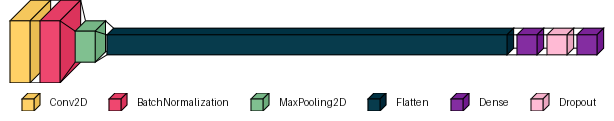


Analyzing train images...
Found 35203 validated image filenames.
Found 8801 validated image filenames.
Training model...
Epoch 1/10


/opt/anaconda3/envs/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-09-25 12:47:21.992830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1101/1101 - 29s - 26ms/step - accuracy: 0.5770 - loss: 16.1178 - val_accuracy: 0.7148 - val_loss: 0.5748 - learning_rate: 0.0010
Epoch 2/10
1101/1101 - 26s - 24ms/step - accuracy: 0.5976 - loss: 1.0964 - val_accuracy: 0.6073 - val_loss: 0.8483 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1101/1101 - 26s - 24ms/step - accuracy: 0.6076 - loss: 1.0570 - val_accuracy: 0.6446 - val_loss: 0.7799 - learning_rate: 0.0010
Epoch 4/10
1101/1101 - 26s - 24ms/step - accuracy: 0.6262 - loss: 0.7618 - val_accuracy: 0.5903 - val_loss: 0.8040 - learning_rate: 5.0000e-04
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1101/1101 - 26s - 24ms/step - accuracy: 0.6259 - loss: 0.8056 - val_accuracy: 0.6815 - val_loss: 0.6118 - learning_rate: 5.0000e-04


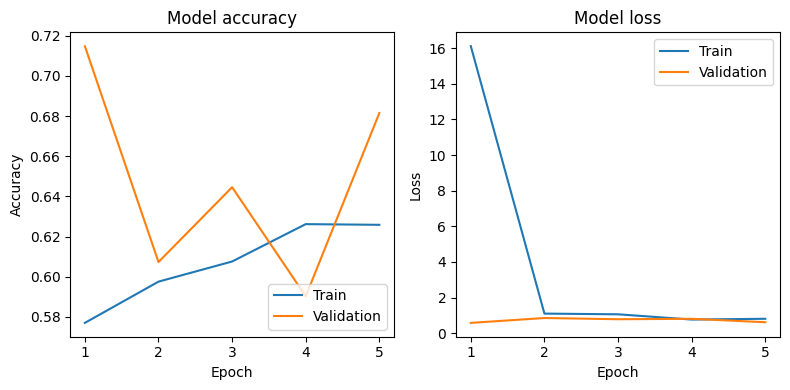

In [10]:
train_df, validate_df = generate_training_data(frac=0.2)

target_size=(64, 64, 3)
model1 = create_model(num_blocks=1, num_convolutions=1, normalize_batches=True, target_size=target_size)
compile_and_fit(train_df=train_df, validate_df=validate_df, model=model1, num_epochs=10)


Looking at the results, the accuracy increases with each epoch for both training and validation data. The loss decreases rapidly during training and stays constantly low for validation.

Next, I will try 2 convolution layers to see what changes


------------------------------------------------------------------------------------------------------------------------------------------------------
MODEL: num_blocks: 1, num_convolutions: 2, normalize_batches: True, dropout_rate: 0.5, regularizer: None
------------------------------------------------------------------------------------------------------------------------------------------------------
Calculating mean and std for each color channel of 500 images...
channel_mean: [0.70767078 0.54990687 0.70064156] channel_std: [0.23303224 0.27681271 0.21118436]


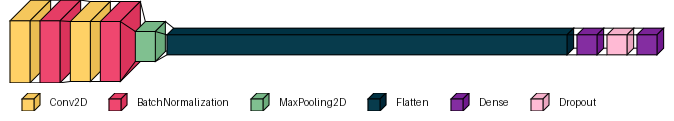


Analyzing train images...
Found 35203 validated image filenames.
Found 8801 validated image filenames.
Training model...

Epoch 1: val_accuracy did not improve from 0.79366

Epoch 2: val_accuracy improved from 0.79366 to 0.80286, saving model to best_model.keras

Epoch 3: val_accuracy improved from 0.80286 to 0.81173, saving model to best_model.keras

Epoch 4: val_accuracy did not improve from 0.81173

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_accuracy did not improve from 0.81173

Epoch 6: val_accuracy improved from 0.81173 to 0.82025, saving model to best_model.keras

Epoch 7: val_accuracy did not improve from 0.82025

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: val_accuracy did not improve from 0.82025

Epoch 9: val_accuracy did not improve from 0.82025

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 10: val_accuracy did not improve from 0.82025


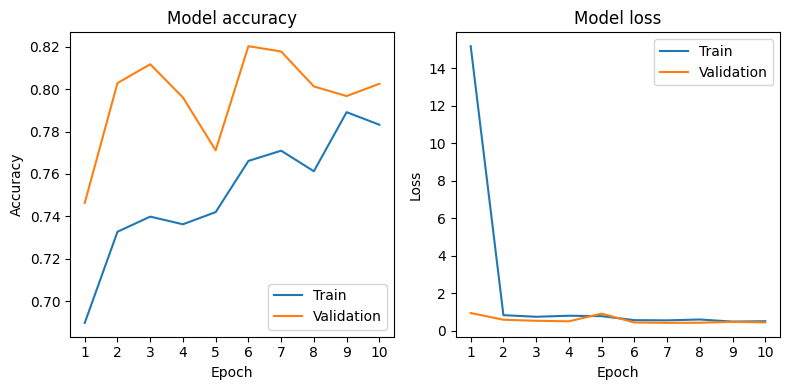

In [260]:
model2 = create_model(num_blocks=1, num_convolutions=2, normalize_batches=True)
compile_and_fit(train_df=train_df, validate_df=validate_df, model=model2, num_epochs=10)


The results are similar in the change of accuracy and loss, but the overall accuracy has improved from 79% to 82%. It seems beneficial to have at least 2 convolution layers.

Next, I will try 3 convolution layers before pooling.


------------------------------------------------------------------------------------------------------------------------------------------------------
MODEL: num_blocks: 1, num_convolutions: 3, normalize_batches: True, dropout_rate: 0.5, regularizer: None
------------------------------------------------------------------------------------------------------------------------------------------------------
Calculating mean and std for each color channel of 500 images...
channel_mean: [0.70767078 0.54990687 0.70064156] channel_std: [0.23303224 0.27681271 0.21118436]


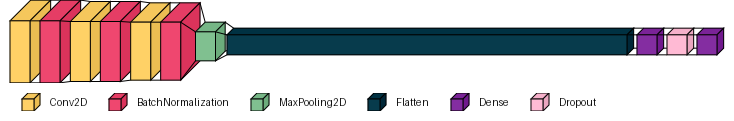


Analyzing train images...
Found 35203 validated image filenames.
Found 8801 validated image filenames.
Training model...

Epoch 1: val_accuracy improved from 0.82025 to 0.82536, saving model to best_model.keras

Epoch 2: val_accuracy did not improve from 0.82536

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_accuracy did not improve from 0.82536

Epoch 4: val_accuracy did not improve from 0.82536

Epoch 5: val_accuracy improved from 0.82536 to 0.83127, saving model to best_model.keras

Epoch 6: val_accuracy did not improve from 0.83127

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 7: val_accuracy did not improve from 0.83127

Epoch 8: val_accuracy did not improve from 0.83127

Epoch 9: val_accuracy improved from 0.83127 to 0.83672, saving model to best_model.keras

Epoch 10: val_accuracy did not improve from 0.83672


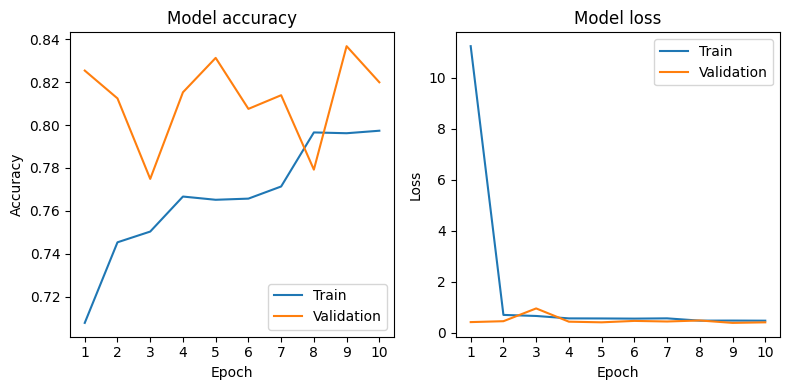

In [261]:
model3 = create_model(num_blocks=1, num_convolutions=3, normalize_batches=True)
compile_and_fit(train_df=train_df, validate_df=validate_df, model=model3, num_epochs=10)


Based on the results of those 3 models, I am going to go forward with 2 convolution layers per block. In the last test, 3 convolution layers had slightly better accuracy, bit it was a bit more erratic during different epochs.

### Architecture Options - How many repeatable convolution blocks should I use?

The next step is to decide on the benefit (or lack thereof) of repeating the convolution steps more than once. Let's see what happens when we try 2 or 3 repeatable blocks with 2 convolutions per block. Between each block, the number of filters used by the model is automatically doubled in the `create_model()` function.


------------------------------------------------------------------------------------------------------------------------------------------------------
MODEL: num_blocks: 2, num_convolutions: 2, normalize_batches: False, dropout_rate: 0.5, regularizer: None
------------------------------------------------------------------------------------------------------------------------------------------------------
Calculating mean and std for each color channel of 500 images...
channel_mean: [0.70767078 0.54990687 0.70064156] channel_std: [0.23303224 0.27681271 0.21118436]


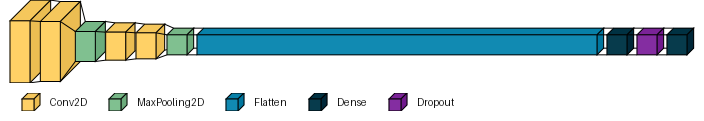


Analyzing train images...
Found 35203 validated image filenames.
Found 8801 validated image filenames.
Training model...

Epoch 1: val_accuracy did not improve from 0.83672

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 2: val_accuracy did not improve from 0.83672

Epoch 3: val_accuracy did not improve from 0.83672

Epoch 4: val_accuracy improved from 0.83672 to 0.84036, saving model to best_model.keras

Epoch 5: val_accuracy did not improve from 0.84036

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 6: val_accuracy did not improve from 0.84036

Epoch 7: val_accuracy did not improve from 0.84036

Epoch 8: val_accuracy improved from 0.84036 to 0.84388, saving model to best_model.keras

Epoch 9: val_accuracy improved from 0.84388 to 0.85661, saving model to best_model.keras

Epoch 10: val_accuracy did not improve from 0.85661


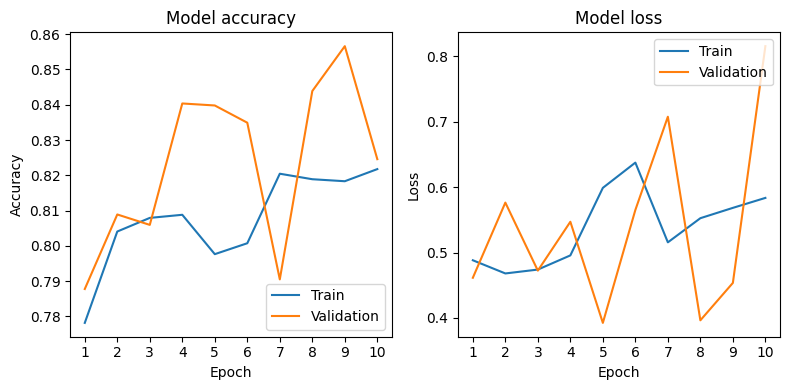

In [263]:
modeb2c2 = create_model(num_blocks=2, num_convolutions=2)
compile_and_fit(train_df=train_df, validate_df=validate_df, model=modeb2c2, num_epochs=10)


The accuracy varies drastically from epoch to epoch, indicating either too high of a learning rate, or perhaps too small of a training set. It's also possible that dropout or regularization could be too aggressive. I will explore different learning rates when I do serious hyperparameter tuning later.

Interestingly, if you stop at the right epoch, the overall accuracy has improved to 85.7%

### Hyperparameter Tuning
Given the architecture of 32 blocks, with 2 convolution layers per block, let's see if we can improve things more with some hyperparameter tuning. I am using KerasTuner with the Hyperband tuning algorithm.

The Hyperband algorithm will optimize resources by abandoning paths that are not performing well, rather than trying every hyperparameter permutation on a model that is validating poorly. It starts with a large number of random hyperparameter configurations (runners) and trains for only a few epochs. The worst configurations are pruned and the remaining ones are trained for more epochs. After repeating this pruning process, only the best configurations are trained for the full `max_epochs`.

During the tuning process, I will try the following architecture configurations:
- Number of convolution blocks, where each block has one or more convolution layers and a pooling layer (1, 2 or 3)
- Number of convolution layers within a block (1 or 2)

For each architecture, I will try the following hyperparameters:
- Adam and RMSProp optimizers
- The initial learning rate for the optimizer (sample in the range .0001 to .01)
- L1, L2, and L1L2 regularization
- A regularization factor for each regularizer (sample in the range .00001 to .01)
- A dropout rate for the final Dense layer (0.1, 0.3, or 0.5)

In [298]:
import keras_tuner as kt

train_df, validate_df = generate_training_data(frac=0.25)
channel_mean, channel_std = calc_image_stats(train_df)
src_image_shape = (96, 96, 3)
train_image_shape = (64, 64, 3)
target_size = train_image_shape[:2]

def get_optimizer(hp):
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        return Adam(learning_rate=hp.Float('adam_learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    else:
        return RMSprop(learning_rate=hp.Float('rmsprop_learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))

def get_regularizer(hp):
    reg_type = hp.Choice('kernel_regularizer_type', values=['l1', 'l2', 'l1_l2'])
    reg_factor = hp.Float('regularizer_factor', min_value=1e-5, max_value=1e-2, sampling='log')
    if reg_type == 'l1':
        return l1(reg_factor)
    elif reg_type == 'l2':
        return l2(reg_factor)
    else: # 'l1_l2'
        return l1_l2(l1=reg_factor, l2=reg_factor)

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=train_image_shape))

    num_blocks = hp.Int('num_blocks', min_value=1, max_value=3)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.2)

    for b in range(num_blocks):
        num_conv = hp.Int(f"num_convolutions_for_block{b+1}", min_value=1, max_value=2)
        for _ in range(num_conv):
            model.add(Conv2D(
                filters=32 * 2**b, # 32, 64, 128
                kernel_size=3,
            ))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=get_regularizer(hp)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=get_optimizer(hp),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Starting hyperparameter tuning with the Hyperband algorithm...")

tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    project_name='best_trials',
    max_epochs=10,
    factor=3,
)

class_weight = calc_class_weight(train_df)
stop_early = EarlyStopping(monitor='val_loss', patience=5)

train_flow = create_image_generator(train_df, train_images_path, channel_mean, channel_std, is_training=False, target_size=target_size)
validate_flow = create_image_generator(validate_df, train_images_path, channel_mean, channel_std, is_training=False, target_size=target_size)

tuner.search(train_flow, validation_data=validate_flow, epochs=15, callbacks=[stop_early], class_weight=class_weight)


Trial 30 Complete [00h 07m 01s]
val_accuracy: 0.8780221939086914

Best val_accuracy So Far: 0.8780221939086914
Total elapsed time: 01h 47m 58s



Tuning complete. Retrieving best hyperparameters...

Hyperparameter Tuning Summary
Search space summary
Default search space size: 10
num_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.2, 'sampling': 'linear'}
num_convolutions_for_block1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
kernel_regularizer_type (Choice)
{'default': 'l1', 'conditions': [], 'values': ['l1', 'l2', 'l1_l2'], 'ordered': False}
regularizer_factor (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
adam_learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sam

/opt/anaconda3/envs/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 652,097 (2.49 MB)

 Trainable params: 651,393 (2.48 MB)

 Non-trainable params: 704 (2.75 KB)

/opt/anaconda3/envs/3.11/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


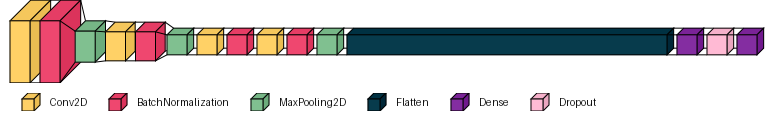


Best accuracy: 87.8%

Best Architecture
Best number of convolution blocks: 3
Best number of convolutions per block: [1, 1, 2]

Best Hyperparameters
Best optimizer: rmsprop
Best learning rate: 0.00028
Best regularizer: l1
Best regularizer factor: 0.00151
Best dropout rate: 0.5


In [329]:
from typing import cast

print("\nTuning complete. Retrieving best hyperparameters...")
print("\nHyperparameter Tuning Summary")
tuner.search_space_summary()

best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_accuracy = best_trial.metrics.get_last_value('val_accuracy')
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0].values
best_model = tuner.get_best_models(num_models=1)[0]

print("\nTuner Results Summary")
print(tuner.results_summary(1))

print("\nBest Model Summary")
best_model.summary()
show_3d_model(best_model)

num_blocks = cast(int, best_hps.get('num_blocks'))
num_convolutions = [best_hps.get(f"num_convolutions_for_block{b}") for b in range(1, num_blocks+1)]
regularizer = best_hps.get('kernel_regularizer_type')
regularizer_factor = best_hps.get('regularizer_factor')
dropout_rate = best_hps.get('dropout_rate')
optimizer = best_hps.get('optimizer')
learning_rate = best_hps.get('rmsprop_learning_rate' if optimizer == 'rmsprop' else 'adam_learning_rate')

print(f'\nBest accuracy: {best_accuracy*100:.1f}%')
print("\nBest Architecture")
print(f"Best number of convolution blocks: {num_blocks}")
print(f"Best number of convolutions per block: {num_convolutions}")

print("\nBest Hyperparameters")
print(f"Best optimizer: {optimizer}")
print(f"Best learning rate: {learning_rate:.5f}")
print(f"Best regularizer: {regularizer}")
print(f"Best regularizer factor: {regularizer_factor:.5f}")
print(f"Best dropout rate: {dropout_rate:.1f}")

# Trial 26 Complete [00h 08m 47s]
# val_accuracy: 0.885748028755188

# Best val_accuracy So Far: 0.885748028755188
# Total elapsed time: 01h 35m 43s


In [315]:
best_model.save('best_model.keras')

## Results and Analysis

The best architecture was 3 blocks, with one Conv2D layer in the first 2 blocks, and two Conv2D layers in the 3rd block with an overall accuracy of 87.8%.

Here is a diagram of the final architecture:

![Model Pipeline](best-model.png)

The best hyperparameters after 30 trial runs:
- Best optimizer: rmsprop
- Best learning rate: 0.00028
- Best regularizer: l1
- Best regularizer factor: 0.00151
- Best dropout rate: 0.5

I will now use the best model to fit on all images and plot the results

In [20]:
from tensorflow.keras.metrics import AUC

best_model = load_model('best_model.keras')
best_model.compile(optimizer=best_model.optimizer, loss=best_model.loss, metrics=['accuracy', AUC()])
train_df, validate_df = generate_training_data(frac=1)
channel_mean, channel_std = calc_image_stats(train_df)
src_image_shape = (96, 96, 3)
train_image_shape = (64, 64, 3)
target_size = train_image_shape[:2]
class_weight = calc_class_weight(train_df)
stop_early = EarlyStopping(monitor='val_loss', patience=5)
train_flow = create_image_generator(train_df, train_images_path, channel_mean, channel_std, is_training=False, target_size=target_size)
validate_flow = create_image_generator(validate_df, train_images_path, channel_mean, channel_std, is_training=False, target_size=target_size)
history2 = best_model.fit(train_flow, validation_data=validate_flow, epochs=15, callbacks=[stop_early], class_weight=class_weight)


/opt/anaconda3/envs/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Splitting data: 80% train, 20% test, and stratifying on label.
Calculating mean and std for each color channel of 500 images...
channel_mean: [0.7031749  0.5440106  0.69671771] channel_std: [0.23536304 0.27656228 0.21184769]
Found 176020 validated image filenames.
Found 44005 validated image filenames.
Epoch 1/15


/opt/anaconda3/envs/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 152s 27ms/step - accuracy: 0.8488 - auc: 0.9254 - loss: 0.4598 - val_accuracy: 0.8869 - val_auc: 0.9521 - val_loss: 0.4095
Epoch 2/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 146s 27ms/step - accuracy: 0.8565 - auc: 0.9317 - loss: 0.4418 - val_accuracy: 0.8873 - val_auc: 0.9523 - val_loss: 0.3854
Epoch 3/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 146s 27ms/step - accuracy: 0.8639 - auc: 0.9375 - loss: 0.4265 - val_accuracy: 0.8925 - val_auc: 0.9574 - val_loss: 0.3786
Epoch 4/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - accuracy: 0.8683 - auc: 0.9405 - loss: 0.4172 - val_accuracy: 0.8844 - val_auc: 0.9513 - val_loss: 0.3868
Epoch 5/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - accuracy: 0.8720 - auc: 0.9434 - loss: 0.4090 - val_accuracy: 0.8537 - val_auc: 0.9506 - val_loss: 0.4588
Epoch 6/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - accuracy: 0.8749 - auc: 0.9451 - loss: 0.4033 - val_accuracy: 0.8959 - val_auc: 0.9599 - val_loss: 0.3631
Epoch 7/15
5501/5501 

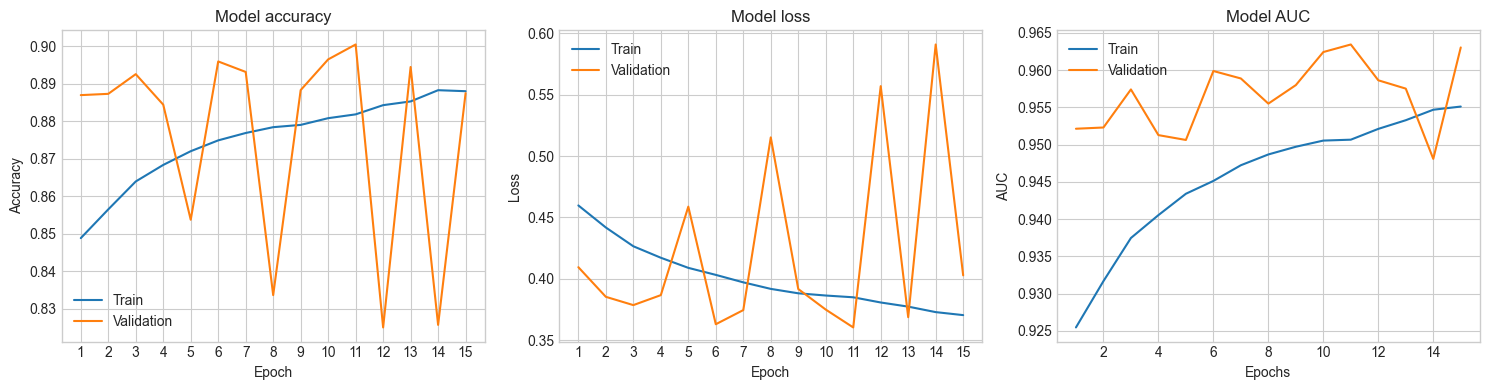

In [25]:
def plot_training_history_with_auc(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    plt_accuracy, plt_loss, plt_auc = ax
    # Plot training & validation accuracy values
    plt_accuracy.plot(epochs, history.history['accuracy'])
    plt_accuracy.plot(epochs, history.history['val_accuracy'])
    plt_accuracy.set_title('Model accuracy')
    plt_accuracy.set_xlabel('Epoch')
    plt_accuracy.set_ylabel('Accuracy')
    plt_accuracy.set_xticks(epochs)
    plt_accuracy.legend(['Train', 'Validation'], loc='lower left')

    # Plot training & validation loss values
    plt_loss.plot(epochs, history.history['loss'])
    plt_loss.plot(epochs, history.history['val_loss'])
    plt_loss.set_title('Model loss')
    plt_loss.set_xlabel('Epoch')
    plt_loss.set_ylabel('Loss')
    plt_loss.set_xticks(epochs)
    plt_loss.legend(['Train', 'Validation'], loc='upper left')

    plt_auc.plot(epochs, history.history['auc'], label='Train')
    plt_auc.plot(epochs, history.history['val_auc'], label='Validation')
    plt_auc.set_title('Model AUC')
    plt_auc.set_xlabel('Epochs')
    plt_auc.set_ylabel('AUC')
    plt_auc.legend()

    plt.tight_layout()
    plt.show()

plot_training_history_with_auc(history2)


The accuracy and loss fluctuate greatly with this model. Perhaps it would settle down after more epochs. The good news is that the accuracy ends close to 90%, but the loss is on a gradual upper trend.

## Conclusion
During this project, I explored a few basic CNN architectures to get on the right track and understand the data. I then used a KerasTuner to try different architectures and hyperparameters to achieve the model with the best accuracy.

### Suggestions for Ways to Improve
1. Transfer Learning: Leveraging pre-trained models like ResNet could boost performance and accuracy. These models have learned powerful generic features from larger datasets and they have most likely discovered tricks that would take me months to discover.
1. Different training validation strategies (e.g., K-Fold Cross-Validation) could provide better generalization
1. Instead of pursuing accuracy during training, I could experiment with optimizing Precision or Recall.
1. Attention Mechanisms: Utilizing attention mechanisms might allow the model to focus on more relevant regions of the image, potentially improving its ability to better identify cancerous areas.
1. Different image preprocessing steps, or more filters, or the way filters change during each layer or block, etc.

### Github Project
https://github.com/kpjava/CU-Boulder-DeepLearning-Cancer-Detection

## Prepare Kaggle Submission

I will use the best performing model to train on the entire image set, and then validate against the test images to prepare a submission to the Kaggle contest.

In [327]:
test_images_path = os.path.join(DATA_DIR, 'test')
test_csv_path = os.path.join(DATA_DIR, 'sample_submission.csv')
test_source_df = pd.read_csv(test_csv_path)
test_source_df['image_name'] = test_source_df['id'].apply(id_to_filename)

validate_flow = create_image_generator(test_source_df, test_images_path, channel_mean, channel_std, is_training=False)
predictions = best_model.predict(validate_flow)
submission_df = pd.DataFrame({
    'id': test_source_df['id'],
    'label': [1 if v > 0.5 else 0 for v in predictions.flatten()]
})
submission_df.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.


/opt/anaconda3/envs/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step
